# Backpropagation with Numpy

For this question, I have checked the link provided in the mail. I actually implmented the code in a slight different way. Classes have different function's than the one provided in the link but the overall functionality persists. The number of Dense layers can be still specified in a list while creating an object of the class. 

The initialize_wights function is called at the time of creating the objects itself. 

The train function takes the training set and validation set in input along with the number of epochs and learning rate.

I have added the plots of training and validation loss and accuracy for better understanding. I have also added matplotlib plots for checking the image, the label and the prediction for test set.

In [1]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from keras.datasets import mnist
import numpy as np
import random
import time
import os

Using TensorFlow backend.


In [2]:
epochs = 30
batch_size = 32

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train/255.0
X_test = X_test/255.0

In [4]:
print('Training shape', X_train.shape)
print('Testing shape', X_test.shape)

Training shape (60000, 28, 28)
Testing shape (10000, 28, 28)


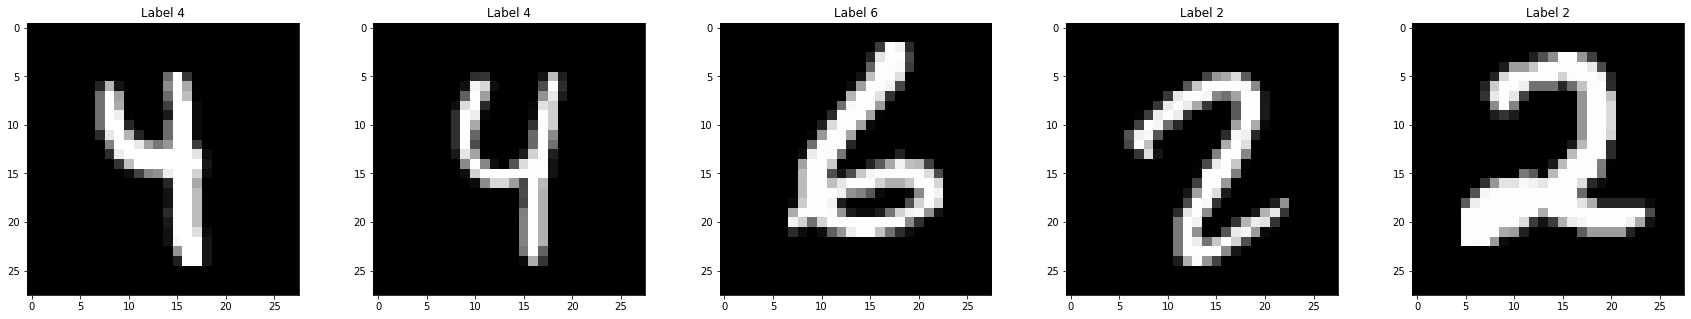

In [5]:
# Training Images
fig, ax = plt.subplots(1,5, figsize=(30,5))
for i in range(0,5):
    index = random.randint(0,60000)
    ax[i].set_title('Label {}'.format(y_train[index]))
    ax[i].imshow(X_train[index], cmap='gray')
plt.show()

In [6]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, shuffle=True, stratify=y_train)

In [7]:
class NeuralNetwork():
    
    def __init__(self, network_dims=[784,128,32,10], batch_size = 32):
        '''
        @params
        network_dims: Give the architecture of a Dense Neural Network. Bias should not be considered why providing the shape here as the class will add it to each layer. \
                      The first number in the list represents the number of neurons in the input layer. \
                      The last layer in this list should be equal to the number of classes as it will be used as the output layer.
        batch_size: The Mini-batch size for training the neural network
        seed: Provide a seed for random number to keep the result consistent
        
        For weights initialization Xavier's Normal initializer is used.
        Mean for the distribution is 0.0 and Standard Deviation is np.sqrt(2/fan_in + fan_out)
        where fan_in: number of input neurons
        fan_out: number of output neurons
        '''
        self.network_dims = network_dims
        self.batch_size = batch_size
        self.weights = self.initialize_weights(self.network_dims)
        
    def initialize_weights(self, network_dims):
        length = len(network_dims)
        weights = {}
        for i in range(length - 1):
            weights['W{}'.format(i)] = np.random.normal(0, np.sqrt((2/(network_dims[i] + network_dims[i+1] + 1))), size=(network_dims[i] + 1, network_dims[i+1] ))
        return weights
        
    def feed_forward(self, x):
        a = x
        activations = [x]
        weighted_sum = []
        size = x.shape[0]
        for i in range(len(self.weights)):
            a = np.hstack((a,np.ones((size, 1)))) # Bias is added here
            z = np.matmul(a,self.weights['W{}'.format(i)])
            weighted_sum.append(z)
            a = self.sigmoid(z)
            activations.append(a)
        return weighted_sum, activations
    
    def train(self, X_train, y_train, X_validation, y_validation, epochs=50, learning_rate = 0.1):
        X_train = np.reshape(X_train, (-1,784))
        X_validation = np.reshape(X_validation, (-1,784))
        train_loss = []
        val_loss = []
        train_accuracy = []
        validation_accuracy = []
        for epoch in range(epochs):
            loss = 0
            for i in range(0, X_train.shape[0], self.batch_size):
                weighted_sum, activations = self.feed_forward(X_train[i:(i + self.batch_size)])
                loss += self.loss_function(activations[-1], y_train[i:(i + self.batch_size)])
                gradients = self.back_propogation(weighted_sum, activations, y_train[i:(i + self.batch_size)])
                self.update_weights(learning_rate, gradients)
            loss = loss / (2 * X_train.shape[0])
            train_loss.append(loss)
            train_acc = self.evaluate(X_train, y_train)
            val_acc = self.evaluate(X_validation, y_validation)
            train_accuracy.append(train_acc)
            validation_accuracy.append(val_acc)
            validation_loss = self.loss_function(self.feed_forward(X_validation)[1][-1], y_validation)/X_validation.shape[0]
            val_loss.append(validation_loss)
            print('Epoch : {0} Training Loss : {1:.3f} Training Accuracy : {2:.3f} Validation Loss : {3:.3f} Validation Accuracy : {4:.3f}'.format(epoch, loss, train_acc, validation_loss, val_acc))
        return {'train_loss': train_loss, 'train_acc': train_accuracy, 'val_acc': validation_accuracy, 'val_loss': val_loss}
    
    def predict(self, X):
        return np.argmax(self.feed_forward(X)[1][-1], axis=-1)
    
    def evaluate(self, X,y):
        return sum(self.predict(X) == y)/X.shape[0]
        
    def back_propogation(self, weighted_sum, activations, y_batch):
        gradients = {}
        delta = self.loss_derivative(activations[-1], y_batch)
        for i in range(len(self.network_dims) - 1):
            activation = np.hstack((activations[-i-2], np.ones((activations[-i-2].shape[0], 1))))
            grad = np.transpose(activation) @ delta
            gradients['W{}'.format(len(self.network_dims) - 2 - i)] = grad
            if (i != (len(self.network_dims) - 2)):
                delta = delta @ np.transpose(self.weights['W{}'.format(len(self.network_dims) - 2 - i)][:-1]) * (activations[-i-2] * (1.0 - activations[-i-2]))
        return gradients
        
    def update_weights(self, learning_rate, gradients):
        for key, value in self.weights.items():
            self.weights[key] -= learning_rate * gradients[key]
    
    def loss_derivative(self, a, y):
        y = to_categorical(y, num_classes=10)
        return (a - y)
        
    def loss_function(self, a, y):
        y = to_categorical(y, num_classes=10)
        return np.sum((a - y)**2)
        
    def sigmoid(self,z):
        return (1.0/ (1.0 + np.exp(-z)))

    def sigmoid_prime(self,z):
        return sigmoid(z) * (1.0 - sigmoid(z))

In [8]:
nn = NeuralNetwork(batch_size=batch_size)

In [9]:
history = nn.train(X_train, y_train, X_validation, y_validation, epochs=epochs)

Epoch : 0 Training Loss : 0.135 Training Accuracy : 0.933 Validation Loss : 0.113 Validation Accuracy : 0.929
Epoch : 1 Training Loss : 0.040 Training Accuracy : 0.963 Validation Loss : 0.072 Validation Accuracy : 0.954
Epoch : 2 Training Loss : 0.030 Training Accuracy : 0.969 Validation Loss : 0.064 Validation Accuracy : 0.960
Epoch : 3 Training Loss : 0.023 Training Accuracy : 0.974 Validation Loss : 0.059 Validation Accuracy : 0.963
Epoch : 4 Training Loss : 0.022 Training Accuracy : 0.975 Validation Loss : 0.059 Validation Accuracy : 0.963
Epoch : 5 Training Loss : 0.020 Training Accuracy : 0.980 Validation Loss : 0.053 Validation Accuracy : 0.967
Epoch : 6 Training Loss : 0.018 Training Accuracy : 0.979 Validation Loss : 0.057 Validation Accuracy : 0.966
Epoch : 7 Training Loss : 0.017 Training Accuracy : 0.982 Validation Loss : 0.054 Validation Accuracy : 0.966
Epoch : 8 Training Loss : 0.017 Training Accuracy : 0.978 Validation Loss : 0.064 Validation Accuracy : 0.961
Epoch : 9 

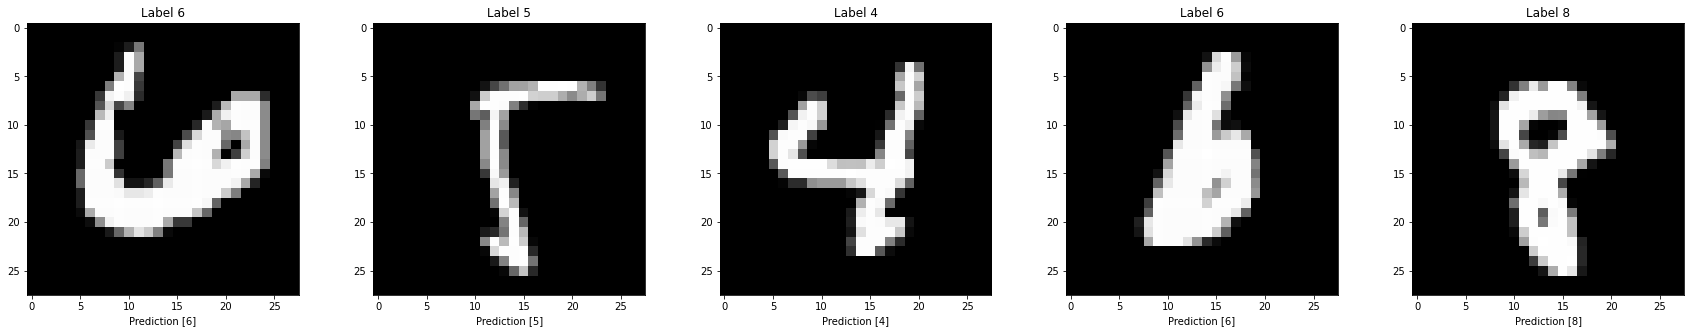

In [10]:
# Training Images
fig, ax = plt.subplots(1,5, figsize=(30,5))
for i in range(0,5):
    index = random.randint(0,10000)
    ax[i].set_title('Label {}'.format(y_test[index]))
    ax[i].imshow(X_test[index], cmap='gray')
    ax[i].set_xlabel('Prediction {}'.format(nn.predict(X_test[index].reshape((-1,784)))))
plt.show()

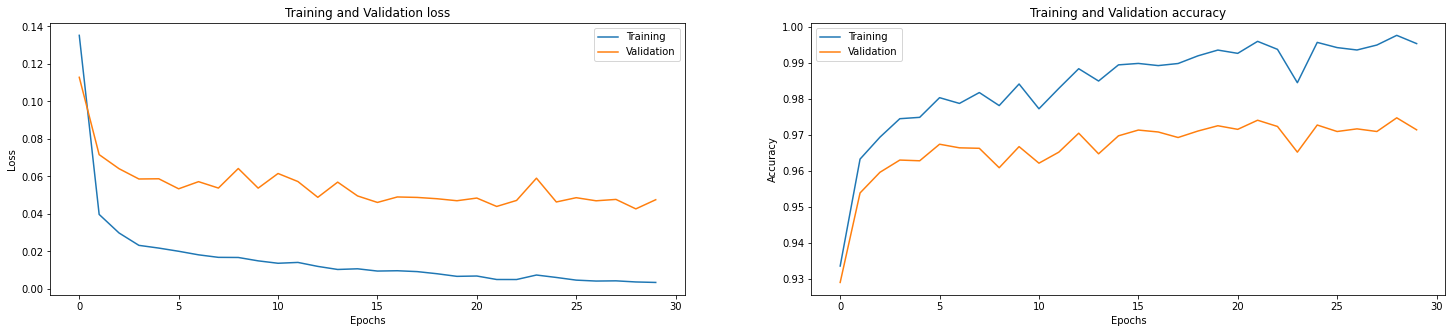

In [11]:
fig, ax = plt.subplots(1,2, figsize=(25,5))
ax[0].plot(range(epochs), history['train_loss'], label='Training')
ax[0].plot(range(epochs), history['val_loss'], label='Validation')
ax[0].set_title('Training and Validation loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(range(epochs), history['train_acc'], label='Training')
ax[1].plot(range(epochs), history['val_acc'], label='Validation')
ax[1].set_title('Training and Validation accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()